In [1]:
import librosa
import librosa.feature
import librosa.display

import numpy as np
np.set_printoptions(suppress=True)

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils.np_utils import to_categorical

from sklearn.metrics import confusion_matrix

import glob

Using TensorFlow backend.


In [20]:
np.seterr(divide='ignore', invalid='ignore')

def generate_features_and_labels():
    clip_duration = 1
    data_len = 44
    song_length = 30

    features = {
        "zcr" : True,
        "rms" : True,
        "spec_cent" : False,
        "spec_bw" : False,
        "spec_flat" : False,
        "spec_roll" : False,
        "spec_cont" : False,
        "chroma" : False
    }
    genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
    
    all_features = []
    all_labels = []
    
    for genre in genres:
        sound_files = glob.glob('genres/'+genre+'/*.wav')
        print('Processing %d songs in %s genre...' % (len(sound_files), genre))
        for f in sound_files:
            for i in range(0, song_length):
                temp_arr = []
                y, sr = librosa.load(f, offset=i, duration=clip_duration)
                S, phase = librosa.magphase(librosa.stft(y=y))
                
                mfcc = librosa.feature.mfcc(y, sr=sr)
                mfcc /= np.amax(np.absolute(mfcc))
                mfcc = np.ndarray.flatten(mfcc)[:data_len * 20]
                
                # pad with 0's
                if np.shape(mfcc)[0] < data_len * 20:
                    mfcc = np.append(mfcc, np.zeros(data_len * 20 - len(mfcc)))
                    assert(len(mfcc == data_len * 20))
                
                    
                if features.get("zcr"):
                    zcr = librosa.feature.zero_crossing_rate(y=y)[0]

                    if np.shape(zcr)[0] < data_len:
                        zcr = np.append(zcr, np.zeros(data_len - len(zcr)))
                        assert(len(zcr) == data_len)
                        

                if features.get("rms"):  
                    rms = librosa.feature.rms(S=S)[0]
                    if np.shape(rms)[0] < data_len:
                        rms = np.append(rms, np.zeros(data_len - len(rms)))
                        assert(len(rms) == data_len)
                    
                    
                if features.get("spec_cent"):
                    cent = librosa.feature.spectral_centroid(S=S)[0]
                    cent /= np.amax(np.absolute(cent))
                    if np.shape(cent)[0] < mfcc_len:
                        cent = np.append(cent, np.zeros(data_len - len(cent)))
                        assert(len(cent) == data_len)

                if features.get("spec_bw"):
                    bw = librosa.feature.spectral_bandwidth(S=S)[0]
                    bw /= np.amax(np.absolute(bw))
                    if np.shape(bw)[0] < data_len:
                        bw = np.append(bw, np.zeros(data_len - len(bw)))
                        assert(len(bw) == data_len)

                if features.get("spec_flat"):
                    flat = librosa.feature.spectral_flatness(S=S)[0]
                    flat /= np.amax(np.absolute(flat))
                    if np.shape(flat)[0] < data_len:
                        flat = np.append(flat, np.zeros(data_len - len(flat)))
                        assert(len(flat) == data_len)
                    
                if features.get("spec_roll"):
                    roll = librosa.feature.spectral_rolloff(S=S)[0]
                    roll /= np.amax(np.absolute(roll))
                    if np.shape(roll)[0] < data_len:
                        roll = np.append(roll, np.zeros(data_len - len(roll)))
                        assert(len(roll) == data_len)
                    
                if features.get("spec_cont"):
                    S = np.abs(librosa.stft(y=y))
                    cont = librosa.feature.spectral_contrast(S=S, sr=sr)
                    cont /= np.amax(np.absolute(cont))
                    cont = np.ndarray.flatten(cont)[:data_len * 7]
                    if np.shape(cont)[0] < data_len * 7:
                        cont = np.append(cont, np.zeros(data_len * 7 - len(cont)))
                        assert(len(cont) == data_len * 7)
                    

                if features.get("chroma"):
                    chroma = librosa.feature.chroma_stft(y=y, sr=sr)[0]
                    chroma /= np.amax(np.absolute(chroma))
                    chroma = np.ndarray.flatten(chroma)[:data_len * 12]
                    if np.shape(chroma)[0] < mfcc_len * 12:
                        chroma = np.append(chroma, np.zeros(data_len * 12 - len(chroma)))
                        assert(len(chroma) == data_len * 12)
                
                # set-up for mfcc + zcr + rms
                ins = np.append(mfcc, zcr)
                ins = np.append(ins, rms)
                all_features.append(ins)
                all_labels.append(genre)
    
    # Convert labels to one-hot encoding
    label_uniq_ids, label_row_ids = np.unique(all_labels, return_inverse=True)
    label_row_ids = label_row_ids.astype(np.int32, copy=False)
    one_hot_labels = to_categorical(label_row_ids, len(label_uniq_ids))
    return np.stack(all_features), one_hot_labels

In [21]:
data = generate_features_and_labels()




Processing 100 songs in blues genre...
Processing 100 songs in classical genre...
Processing 100 songs in country genre...
Processing 100 songs in disco genre...
Processing 100 songs in hiphop genre...
Processing 100 songs in jazz genre...
Processing 100 songs in metal genre...
Processing 100 songs in pop genre...
Processing 100 songs in reggae genre...
Processing 100 songs in rock genre...


In [22]:
features = data[0]
labels = data[1]

print(np.shape(features))
print(np.shape(labels))

(30000, 968)
(30000, 10)


In [23]:
training_split = 0.8

# last column has a genre, turn it into unique ids
alldata = np.column_stack((features, labels))

np.random.shuffle(alldata)
splitidx = int(len(alldata) * training_split)
train, test = alldata[:splitidx,:], alldata[splitidx:,:]

print(np.shape(train))
print(np.shape(test))

(24000, 978)
(6000, 978)


In [24]:
train_input = train[:,:-10]
train_labels = train[:,-10:]

test_input = test[:,:-10]
test_labels = test[:,-10:]

print(np.shape(train_input))
print(np.shape(train_labels))
print(np.shape(test_input))
print(np.shape(test_labels))

(24000, 968)
(24000, 10)
(6000, 968)
(6000, 10)


In [25]:
act = 'relu'
model = Sequential([
    Dense(400, input_dim=np.shape(train_input)[1]),
    Activation(act),
    Dense(200),
    Activation(act),
    Dense(100),
    Activation(act),
    
    Dense(10),
    Activation('softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
          
print(model.summary())
    
history = model.fit(train_input, train_labels, epochs=20, batch_size=32, 
                    validation_split=0.2, shuffle=True)

loss, acc = model.evaluate(test_input, test_labels, batch_size=32)
print("Loss: %.4f, accuracy: %.4f" % (loss, acc))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 400)               387600    
_________________________________________________________________
activation_1 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               80200     
_________________________________________________________________
activation_2 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
activation_3 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

In [26]:
train_scores = model.evaluate(train_input, train_labels, verbose=0)
test_scores = model.evaluate(test_input, test_labels, verbose=0)
print("Train: %s: %.2f%%" % (model.metrics_names[1], train_scores[1]*100))
print("Test: %s: %.2f%%" % (model.metrics_names[1], test_scores[1]*100))

Train: accuracy: 92.95%
Test: accuracy: 76.65%


In [28]:
predictions = model.predict(test_input)

matrix = confusion_matrix(test_labels.argmax(axis=1), predictions.argmax(axis=1))
print(matrix)

[[429   6  46  22  24  27  24   0   7  30]
 [  1 558  13   2   4  18   2   0   1   6]
 [ 18  11 431  20  14  21   3   7   7  44]
 [  2   9  17 400  22  13  10   9  14  53]
 [  9   2  18  34 482  10  19  19  35  19]
 [ 11  26  39   3  10 540   0   2   4  14]
 [  4   0   6   8   5   1 536   0   1  30]
 [  0   5  25  28  41   7   1 441  18  22]
 [ 13   3  45  25  60  25   6   7 351  30]
 [  4   7  38  40  24  23  28  10  10 431]]


In [29]:
M = np.zeros((10, 10))
for i in range(10):
    total = np.sum(matrix[i])
    for j in range(10):
        M[i, j] = round((matrix[i,j]/total * 100), 1)

print(M)

[[69.8  1.   7.5  3.6  3.9  4.4  3.9  0.   1.1  4.9]
 [ 0.2 92.2  2.1  0.3  0.7  3.   0.3  0.   0.2  1. ]
 [ 3.1  1.9 74.8  3.5  2.4  3.6  0.5  1.2  1.2  7.6]
 [ 0.4  1.6  3.1 72.9  4.   2.4  1.8  1.6  2.6  9.7]
 [ 1.4  0.3  2.8  5.3 74.5  1.5  2.9  2.9  5.4  2.9]
 [ 1.7  4.   6.   0.5  1.5 83.2  0.   0.3  0.6  2.2]
 [ 0.7  0.   1.   1.4  0.8  0.2 90.7  0.   0.2  5.1]
 [ 0.   0.9  4.3  4.8  7.   1.2  0.2 75.   3.1  3.7]
 [ 2.3  0.5  8.   4.4 10.6  4.4  1.1  1.2 62.1  5.3]
 [ 0.7  1.1  6.2  6.5  3.9  3.7  4.6  1.6  1.6 70.1]]


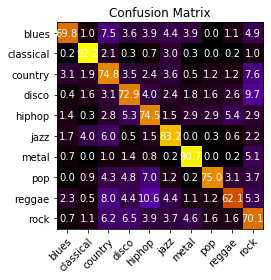

In [30]:
import matplotlib
import matplotlib.pyplot as plt

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

fig, ax = plt.subplots()
im = ax.imshow(M, cmap='gnuplot')

ax.set_xticks(np.arange(len(genres)))
ax.set_yticks(np.arange(len(genres)))

ax.set_xticklabels(genres)
ax.set_yticklabels(genres)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(genres)):
    for j in range(len(genres)):
        text = ax.text(j, i, M[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Confusion Matrix")
fig.tight_layout()
plt.show()



In [36]:
# example classifying a song on MFCC + zcr + rms
filename = "songs/born_in_winter.wav"
song_length = int(librosa.get_duration(filename=filename))
feats = np.zeros((song_length, (20 + 1 + 1) * 44)) # 20 for MFCC, 1 for zcr and 1 for rms

flat_mfcc = 20 * 44
data_len = 44

for i in range(0, song_length):
    y, sr = librosa.load(filename, offset=i, duration=1)
    mfcc = librosa.feature.mfcc(y, sr=sr)
    mfcc /= np.amax(np.absolute(mfcc))
    mfcc = np.ndarray.flatten(mfcc)[:flat_mfcc]
    
    if np.shape(mfcc)[0] < flat_mfcc:
        mfcc = np.append(mfcc, np.zeros(flat_mfcc - len(mfcc)))
        assert(len(mfcc) == flat_mfcc)
        
    zcr = librosa.feature.zero_crossing_rate(y=y)[0]
    if np.shape(zcr)[0] < data_len:
        zcr = np.append(zcr, np.zeros(data_len - len(zcr)))
        assert(len(zcr) == 44)
                        
    S, phase = librosa.magphase(librosa.stft(y=y))
    rms = librosa.feature.rms(S=S)[0]
    if np.shape(rms)[0] < data_len:
        rms = np.append(rms, np.zeros(data_len - len(rms)))
        assert(len(rms) == 44)
    
    entry = np.append(mfcc, zcr)
    entry = np.append(entry, rms)
    feats[i] = entry
    
# for every second in the song feats now contains a prediction array of length 10 representing the genres

In [39]:
genre_per_second = []
out = np.zeros(10)
for i in range(0, song_length):
    pred = model.predict(feats[i:i+1,])
    
    out += pred[0]
    genre_per_second = np.append(genre_per_second, np.argmax(pred))

out /= song_length

In [40]:
# prints for every second which genre had the highest prediction
# 0 for blues, 1 for classical etc. according the indices of
# ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
print(genre_per_second)

[5. 2. 2. 2. 2. 2. 2. 4. 4. 4. 5. 4. 4. 5. 5. 5. 4. 5. 4. 5. 4. 5. 5. 5.
 4. 5. 5. 5. 5. 9. 5. 5. 5. 4. 5. 5. 5. 5. 5. 9. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 9. 9. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 9. 5. 5. 5. 9. 5. 5.
 5. 4. 5. 5. 5. 5. 5. 0. 9. 5. 5. 5. 5. 5. 4. 4. 5. 5. 5. 5. 5. 5. 5. 5.
 4. 5. 5. 5. 5. 5. 5. 5. 5. 5. 9. 5. 5. 5. 2. 2. 2. 2. 2. 9. 2. 2. 2. 2.
 2. 2. 9. 9. 9. 2. 9. 2. 2. 2. 9. 2. 2. 2. 2. 9. 2. 9. 9. 9. 2. 2. 2. 2.
 6. 2. 2. 2. 2. 2. 2. 6. 2. 2. 2. 2. 2. 2. 2. 2. 2. 9. 2. 2. 2. 1. 2. 2.
 2. 2. 9. 2. 2. 9. 2. 2. 9. 2. 2. 2. 9. 2. 9. 2. 9. 9. 9. 9. 5. 4. 4. 2.
 4. 5. 4. 5. 5. 4. 4. 5. 4. 5. 0. 4. 5. 5. 5. 4. 5. 6. 4. 4. 5. 4. 4. 4.
 5. 5. 5. 4. 5. 6. 5. 5. 6. 0. 1. 1. 1. 4.]


In [41]:
# prints the total prediction for every genre
# array to be read in the order of 
# ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
print(out)

[0.0196113  0.01999955 0.27268202 0.00101348 0.13733902 0.4139647
 0.02215203 0.0000354  0.00002015 0.11318235]


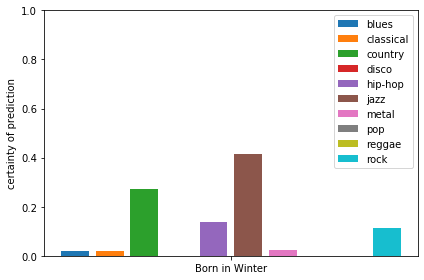

In [50]:
labels = ['Gojira - Born in Winter']

x = np.arange(len(labels))

fig, ax = plt.subplots()


rects1 = ax.bar(x - 4.5*width, out[0], label='blues')
rects2 = ax.bar(x - 3.5*width, out[1], label='classical')
rects3 = ax.bar(x - 2.5*width, out[2], label='country')
rects4 = ax.bar(x - 1.5*width, out[3], label='disco')
rects5 = ax.bar(x - 0.5*width, out[4], label='hip-hop')
rects6 = ax.bar(x + 0.5*width, out[5], label='jazz')
rects7 = ax.bar(x + 1.5*width, out[6], label='metal')
rects8 = ax.bar(x + 2.5*width, out[7], label='pop')
rects9 = ax.bar(x + 3.5*width, out[8], label='reggae')
rects10 = ax.bar(x + 4.5*width, out[9], label='rock')



# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('certainty of prediction')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.ylim([0, 1])

fig.tight_layout()

plt.show()